# Time Series with Tensorflow Dataset

## 1. Import the data and libraries

In [18]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, RNN, Dense, LSTM, Bidirectional, SimpleRNN
from tensorflow.keras.optimizers import SGD

### Prepare the data

In [19]:
dataset = tf.data.Dataset.range(10)

In [20]:
for val in dataset: 
  print(val.numpy())

0
1
2
3
4
5
6
7
8
9


## 2. Preprocess the data

### Shift the data to the future timeline

In [21]:
dataset = dataset.window(5, shift=1 , drop_remainder=True)

In [22]:
for window in dataset: 
  for val in window: 
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [23]:
dataset = dataset.flat_map(lambda window: window.batch(5))

In [24]:
for window in dataset: 
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [25]:
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

In [26]:
for window in dataset: 
  print(window)

(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 3, 4, 5])>, <tf.Tensor: shape=(), dtype=int64, numpy=6>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 4, 5, 6])>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([4, 5, 6, 7])>, <tf.Tensor: shape=(), dtype=int64, numpy=8>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([5, 6, 7, 8])>, <tf.Tensor: shape=(), dtype=int64, numpy=9>)


In [27]:
dataset = dataset.shuffle(buffer_size=10)

In [28]:
for window in dataset: 
  print(window)

(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([5, 6, 7, 8])>, <tf.Tensor: shape=(), dtype=int64, numpy=9>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>, <tf.Tensor: shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([4, 5, 6, 7])>, <tf.Tensor: shape=(), dtype=int64, numpy=8>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 4, 5, 6])>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 3, 4, 5])>, <tf.Tensor: shape=(), dtype=int64, numpy=6>)


In [29]:
dataset = dataset.batch(2)

In [30]:
for window in dataset:
  print(window)

(<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[3, 4, 5, 6],
       [0, 1, 2, 3]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 4])>)
(<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 3, 4, 5],
       [5, 6, 7, 8]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([6, 9])>)
(<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[4, 5, 6, 7],
       [1, 2, 3, 4]])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([8, 5])>)


### Important function

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None): 
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope=0): 
  return slope*time

def seasonal_pattern(season_time): 
  return np.where(season_time < 0.4, 
                  np.cos(season_time * 2 * np.pi), 
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0): 
  season_time = ((time+phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None): 
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [32]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [33]:
# Create the series 
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

#Update with noise
series += noise(time, noise_level, seed=42)

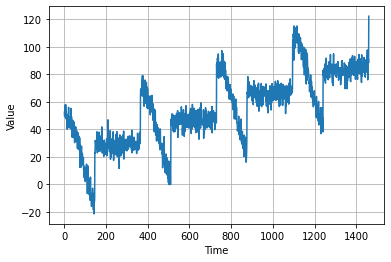

In [34]:
plot_series(time, series)

## Define the constants

In [35]:
window_size = 20
batch_size = 32
shuffle_size = 1000

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [36]:
def windowed_ds(series, window_size, batch_size, shuffle_size): 
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Shift the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  # Flat_map to ensure the order of the dataset is the same
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Shuffle the dataset
  dataset = dataset.shuffle(shuffle_size).map(lambda window: (window[:-1], window[-1]))

  # Prefetch to reduce the step time toi the maxium and the time to extract the data
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [37]:
dataset = windowed_ds(series, window_size, batch_size, shuffle_size)

## 3. Create the model

In [38]:
model = Sequential([
                    Dense(10, input_shape=[window_size], activation='relu'), 
                    Dense(10, activation='relu'), 
                    Dense(1)
])

model.compile(loss='mse', optimizer=SGD(lr=1e-6, momentum=0.9))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [39]:
history = model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
46/46 [==============================] - 0s 3ms/step - loss: 415.8874
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 67.6833
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 66.3140
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 64.1212
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 69.5340
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 60.8950
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 59.9745
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 59.3421
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 57.7647
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 56.7173
Epoch 11/100
46/46 [==============================] - 0s 3ms/step - loss: 55.4798
Epoch 12/100
46/46 [==============================] - 0s 3ms/step - loss: 54.9671
Epoch 13/100
46/46 [====

## 4. Do the prediction

In [42]:
forecast = []

for time in range(len(series) - window_size): 
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

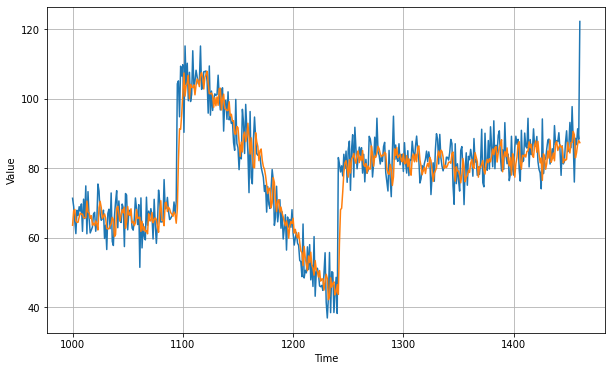

In [47]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)